In [46]:
# credit: https://www.kaggle.com/niharika41298/product-recommendations-plotly-dash-interactive-ui/notebook
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import json
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array, ImageDataGenerator
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from keras import layers, optimizers, utils
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [2]:
# install kaggle
# we will import our data set directly from kaggle

! pip install kaggle

In [3]:
! mkdir /content/.kaggle

mkdir: cannot create directory ‘/content/.kaggle’: File exists


In [ ]:
# upload kaggle API to sample_data before running this code block
# (Tutorial: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)
! cp /content/sample_data/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paramaggarwal/fashion-product-images-small

In [ ]:
! unzip fashion-product-images-small.zip

In [56]:
imgs_path = "/content/images/"
imgs_model_width, imgs_model_height = 224, 224
nb_closest_images = 5

In [57]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]
print("Total number of images:",len(files))

Total number of images: 44441


In [58]:
# In order to reduce compilation time of the algorithm, we reduce the data to 500 images
files=files[0:500]

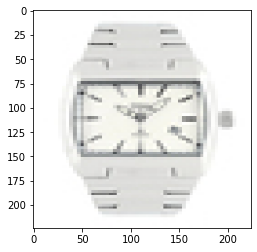

In [60]:
# visualize our data set
original = load_img(files[5], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()

In [61]:
from keras import models
# load the model - Vgg16
# introduction of the model: https://medium.com/@mygreatlearning/what-is-vgg16-introduction-to-vgg16-f2d63849f615
vgg_model = vgg16.VGG16(weights='imagenet')

# # remove the last layers in order to get features instead of predictions
model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [62]:
# since vgg16 can only process one image at a time, we train the model with 'original' first
numpy_image = img_to_array(original)

# convert the image / images into batch format
image_batch = np.expand_dims(numpy_image, axis=0)
print('Image Batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

Image Batch size (1, 224, 224, 3)


In [63]:
# predict our training data
img_features = model.predict(processed_image)
img_features

array([[1.2384202, 0.       , 0.       , ..., 0.5392959, 0.       ,
        3.4579988]], dtype=float32)

In [69]:
# now we run all 500 images we extracted through our model
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [68]:
imgs_features = model.predict(processed_imgs)

In [70]:
# now find the cosine similarities between each images
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/images/24274.jpg,/content/images/43687.jpg,/content/images/22612.jpg,/content/images/18634.jpg,/content/images/24941.jpg,/content/images/45875.jpg,/content/images/7780.jpg,/content/images/56455.jpg,/content/images/4130.jpg,/content/images/40198.jpg,/content/images/21344.jpg,/content/images/16441.jpg,/content/images/51424.jpg,/content/images/53114.jpg,/content/images/23263.jpg,/content/images/37094.jpg,/content/images/7060.jpg,/content/images/35092.jpg,/content/images/44446.jpg,/content/images/4593.jpg,/content/images/13874.jpg,/content/images/36382.jpg,/content/images/28599.jpg,/content/images/18665.jpg,/content/images/6304.jpg,/content/images/49523.jpg,/content/images/3911.jpg,/content/images/37450.jpg,/content/images/41879.jpg,/content/images/35409.jpg,/content/images/15235.jpg,/content/images/49232.jpg,/content/images/44757.jpg,/content/images/57329.jpg,/content/images/19200.jpg,/content/images/11790.jpg,/content/images/36499.jpg,/content/images/24755.jpg,/content/images/19830.jpg,/content/images/54319.jpg,...,/content/images/55221.jpg,/content/images/33618.jpg,/content/images/47692.jpg,/content/images/17232.jpg,/content/images/7329.jpg,/content/images/7715.jpg,/content/images/21618.jpg,/content/images/17075.jpg,/content/images/23474.jpg,/content/images/17211.jpg,/content/images/57824.jpg,/content/images/36559.jpg,/content/images/12414.jpg,/content/images/54622.jpg,/content/images/12346.jpg,/content/images/56346.jpg,/content/images/13174.jpg,/content/images/41992.jpg,/content/images/25985.jpg,/content/images/46795.jpg,/content/images/18839.jpg,/content/images/44824.jpg,/content/images/30764.jpg,/content/images/43237.jpg,/content/images/42684.jpg,/content/images/43846.jpg,/content/images/35438.jpg,/content/images/6581.jpg,/content/images/28547.jpg,/content/images/17784.jpg,/content/images/48142.jpg,/content/images/10865.jpg,/content/images/53749.jpg,/content/images/43388.jpg,/content/images/22573.jpg,/content/images/39156.jpg,/content/images/50016.jpg,/content/images/45095.jpg,/content/images/40120.jpg,/content/images/3350.jpg
/content/images/24274.jpg,1.000000,0.359362,0.471643,0.642062,0.461697,0.452080,0.330689,0.416628,0.234257,0.634479,0.335775,0.664416,0.671246,0.629937,0.438392,0.521406,0.299324,0.514434,0.303941,0.457719,0.698578,0.440208,0.298917,0.294902,0.237936,0.277462,0.528351,0.260931,0.307689,0.265031,0.404588,0.361323,0.323274,0.459492,0.727923,0.586646,0.583613,0.425070,0.746488,0.390197,...,0.361618,0.334593,0.415097,0.695769,0.329840,0.316371,0.259670,0.287870,0.541866,0.302867,0.451837,0.658031,0.366262,0.485492,0.508746,0.501437,0.382771,0.412161,0.498877,0.287046,0.279379,0.227467,0.598546,0.318641,0.547931,0.493488,0.465615,0.528968,0.518276,0.427888,0.367550,0.719429,0.423943,0.291394,0.639135,0.532170,0.570134,0.579730,0.608961,0.625064
/content/images/43687.jpg,0.359362,1.000000,0.521039,0.359029,0.623569,0.452070,0.555438,0.550904,0.335973,0.464161,0.437414,0.543689,0.500337,0.394696,0.441359,0.461600,0.382773,0.433592,0.411919,0.455337,0.368314,0.497366,0.415331,0.359237,0.310227,0.430066,0.430069,0.334720,0.409661,0.319670,0.426202,0.473765,0.349419,0.472405,0.396436,0.574783,0.422959,0.464053,0.416599,0.446754,...,0.518686,0.512407,0.510369,0.479304,0.368094,0.363596,0.411065,0.352788,0.436824,0.447930,0.428586,0.333922,0.540040,0.375559,0.368598,0.402058,0.410317,0.513870,0.454029,0.402137,0.320707,0.379567,0.405992,0.347682,0.465531,0.464403,0.696546,0.508204,0.625621,0.519179,0.516045,0.439920,0.420019,0.437483,0.413314,0.385715,0.507417,0.546406,0.411905,0.437076
/content/images/22612.jpg,0.471643,0.521039,1.000000,0.497301,0.561856,0.339955,0.336304,0.337778,0.246242,0.463253,0.321944,0.537756,0.428358,0.453619,0.291890,0.380130,0.298045,0.451016,0.269039,0.294313,0.494355,0.366465,0.315944,0.268912,0.311098,0.263474,0.419569,0.245300,0.332322,0.256745,0.409489,0.366026,0.360654,0.367375,0.449954,0.458057,0.430546,0.384459,0.494055,0.402249,...,0.364190,0.343397,0.378014,0.428449

In [96]:
def recommended_outfit(img):
  """
  retrieve the most similar 5 products for the imputted image

  arguements:
  img: image that is going to be used to find its most similar products

  return: none
  """
  print("Original product:")

  original = load_img(img, target_size=(imgs_model_width, imgs_model_height))
  plt.imshow(original)
  plt.show()

  print("\n\nMost similar products:")

  closest_imgs = cos_similarities_df[img].sort_values(ascending=False)[1:nb_closest_images+1].index
  closest_imgs_scores = cos_similarities_df[img].sort_values(ascending=False)[1:nb_closest_images+1]

  for i in range(len(closest_imgs)):
      original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
      plt.imshow(original)
      plt.show()
      print("similarity score : ",closest_imgs_scores[i])
      print("\n\n")

Original product:


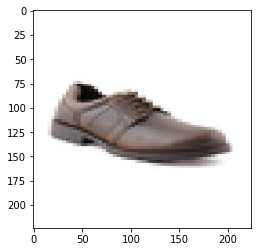



Most similar products:


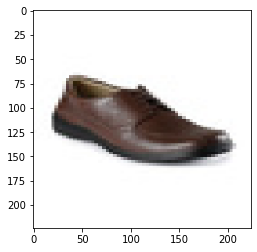

similarity score :  0.81384695





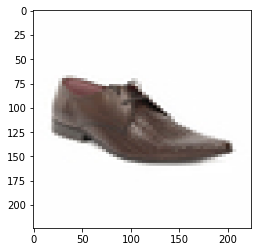

similarity score :  0.78934586





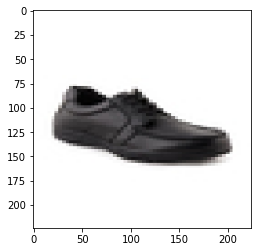

similarity score :  0.782443





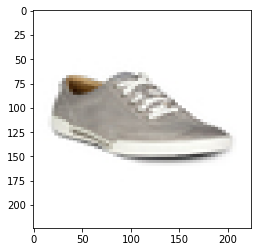

similarity score :  0.78206307





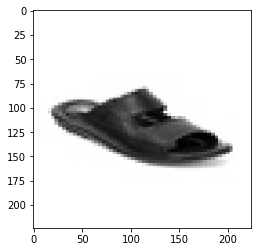

similarity score :  0.77827114





In [97]:
recommended_outfit(files[50])